In [1]:
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple
import numpy as np
import requests
from torchvision import utils as vutils
from torchvision.models import vgg16
import albumentations
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [2]:
"""
helpers
"""
class GroupNorm(nn.Module):
    def __init__(self, channels):
        super(GroupNorm, self).__init__()
        self.gn = nn.GroupNorm(num_groups=32, num_channels=channels, eps=1e-6, affine=True)

    def forward(self, x):
        return self.gn(x)


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.block = nn.Sequential(
            GroupNorm(in_channels),
            Swish(),
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            GroupNorm(out_channels),
            Swish(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        )

        if in_channels != out_channels:
            self.channel_up = nn.Conv2d(in_channels, out_channels, 1, 1, 0)

    def forward(self, x):
        if self.in_channels != self.out_channels:
            return self.channel_up(x) + self.block(x)
        else:
            return x + self.block(x)


class UpSampleBlock(nn.Module):
    def __init__(self, channels):
        super(UpSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 1, 1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0)
        return self.conv(x)


class DownSampleBlock(nn.Module):
    def __init__(self, channels):
        super(DownSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 2, 0)

    def forward(self, x):
        pad = (0, 1, 0, 1)
        x = F.pad(x, pad, mode="constant", value=0)
        return self.conv(x)


class NonLocalBlock(nn.Module):
    def __init__(self, channels):
        super(NonLocalBlock, self).__init__()
        self.in_channels = channels

        self.gn = GroupNorm(channels)
        self.q = nn.Conv2d(channels, channels, 1, 1, 0)
        self.k = nn.Conv2d(channels, channels, 1, 1, 0)
        self.v = nn.Conv2d(channels, channels, 1, 1, 0)
        self.proj_out = nn.Conv2d(channels, channels, 1, 1, 0)

    def forward(self, x):
        h_ = self.gn(x)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        b, c, h, w = q.shape

        q = q.reshape(b, c, h*w)
        q = q.permute(0, 2, 1)
        k = k.reshape(b, c, h*w)
        v = v.reshape(b, c, h*w)

        attn = torch.bmm(q, k)
        attn = attn * (int(c)**(-0.5))
        attn = F.softmax(attn, dim=2)
        attn = attn.permute(0, 2, 1)

        A = torch.bmm(v, attn)
        A = A.reshape(b, c, h, w)

        return x + A

In [3]:
"""
模型一些重要的组件
encoder
decoder
codebook
vqgan
"""
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()
        channels = [128, 128, 128, 256, 256, 512]
        attn_resolutions = [16]
        num_res_blocks = 2
        resolution = 256
        layers = [nn.Conv2d(args.image_channels, channels[0], 3, 1, 1)]
        for i in range(len(channels)-1):
            in_channels = channels[i]
            out_channels = channels[i + 1]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != len(channels)-2:
                layers.append(DownSampleBlock(channels[i+1]))
                resolution //= 2
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(NonLocalBlock(channels[-1]))
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(GroupNorm(channels[-1]))
        layers.append(Swish())
        layers.append(nn.Conv2d(channels[-1], args.latent_dim, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    

class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()
        channels = [512, 256, 256, 128, 128]
        attn_resolutions = [16]
        num_res_blocks = 3
        resolution = 16

        in_channels = channels[0]
        layers = [nn.Conv2d(args.latent_dim, in_channels, 3, 1, 1),
                  ResidualBlock(in_channels, in_channels),
                  NonLocalBlock(in_channels),
                  ResidualBlock(in_channels, in_channels)]

        for i in range(len(channels)):
            out_channels = channels[i]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != 0:
                layers.append(UpSampleBlock(in_channels))
                resolution *= 2

        layers.append(GroupNorm(in_channels))
        layers.append(Swish())
        layers.append(nn.Conv2d(in_channels, args.image_channels, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class Codebook(nn.Module):
    def __init__(self, args):
        super(Codebook, self).__init__()
        self.num_codebook_vectors = args.num_codebook_vectors
        self.latent_dim = args.latent_dim
        self.beta = args.beta

        self.embedding = nn.Embedding(self.num_codebook_vectors, self.latent_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.num_codebook_vectors, 1.0 / self.num_codebook_vectors)

    def forward(self, z):
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.latent_dim)

        # (z_flattened-embedding.weight)^2
        # z_flat [1024, 256] embedding [1024, 256] 要获得1024,1024大小得(a-b)^2
        d = torch.sum(z_flattened**2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - \
            2*(torch.matmul(z_flattened, self.embedding.weight.t()))

        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z.shape)

        loss = torch.mean((z_q.detach() - z)**2) + self.beta * torch.mean((z_q - z.detach())**2)

        z_q = z + (z_q - z).detach()

        z_q = z_q.permute(0, 3, 1, 2)

        return z_q, min_encoding_indices, loss
    


class VQGAN(nn.Module):
    def __init__(self, args):
        super(VQGAN, self).__init__()
        self.encoder = Encoder(args).to(device=args.device)
        self.decoder = Decoder(args).to(device=args.device)
        self.codebook = Codebook(args).to(device=args.device)
        self.quant_conv = nn.Conv2d(args.latent_dim, args.latent_dim, 1).to(device=args.device)
        self.post_quant_conv = nn.Conv2d(args.latent_dim, args.latent_dim, 1).to(device=args.device)

    def forward(self, imgs):
        encoded_images = self.encoder(imgs)
        quant_conv_encoded_images = self.quant_conv(encoded_images)
        codebook_mapping, codebook_indices, q_loss = self.codebook(quant_conv_encoded_images)
        post_quant_conv_mapping = self.post_quant_conv(codebook_mapping)
        decoded_images = self.decoder(post_quant_conv_mapping)

        return decoded_images, codebook_indices, q_loss

    def encode(self, imgs):
        encoded_images = self.encoder(imgs)
        quant_conv_encoded_images = self.quant_conv(encoded_images)
        codebook_mapping, codebook_indices, q_loss = self.codebook(quant_conv_encoded_images)
        return codebook_mapping, codebook_indices, q_loss

    def decode(self, z):
        post_quant_conv_mapping = self.post_quant_conv(z)
        decoded_images = self.decoder(post_quant_conv_mapping)
        return decoded_images

    def calculate_lambda(self, perceptual_loss, gan_loss):
        last_layer = self.decoder.model[-1]
        last_layer_weight = last_layer.weight
        perceptual_loss_grads = torch.autograd.grad(perceptual_loss, last_layer_weight, retain_graph=True)[0]
        gan_loss_grads = torch.autograd.grad(gan_loss, last_layer_weight, retain_graph=True)[0]

        λ = torch.norm(perceptual_loss_grads) / (torch.norm(gan_loss_grads) + 1e-4)
        λ = torch.clamp(λ, 0, 1e4).detach()
        return 0.8 * λ

    @staticmethod
    def adopt_weight(disc_factor, i, threshold, value=0.):
        if i < threshold:
            disc_factor = value
        return disc_factor

    def load_checkpoint(self, path):
        self.load_state_dict(torch.load(path))







In [4]:
"""
utils&helpers
"""

class NetLinLayer(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super(NetLinLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        )


class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        self.register_buffer("shift", torch.Tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer("scale", torch.Tensor([.458, .448, .450])[None, :, None, None])

    def forward(self, x):
        return (x - self.shift) / self.scale
    


class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        vgg_pretrained_features = vgg16(pretrained=True).features
        slices = [vgg_pretrained_features[i] for i in range(30)]
        self.slice1 = nn.Sequential(*slices[0:4])
        self.slice2 = nn.Sequential(*slices[4:9])
        self.slice3 = nn.Sequential(*slices[9:16])
        self.slice4 = nn.Sequential(*slices[16:23])
        self.slice5 = nn.Sequential(*slices[23:30])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1 = h
        h = self.slice2(h)
        h_relu2 = h
        h = self.slice3(h)
        h_relu3 = h
        h = self.slice4(h)
        h_relu4 = h
        h = self.slice5(h)
        h_relu5 = h
        vgg_outputs = namedtuple("VGGOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        return vgg_outputs(h_relu1, h_relu2, h_relu3, h_relu4, h_relu5)
    


URL_MAP = {
    "vgg_lpips": "https://heibox.uni-heidelberg.de/f/607503859c864bc1b30b/?dl=1"
}

CKPT_MAP = {
    "vgg_lpips": "vgg.pth"
}


def download(url, local_path, chunk_size=1024):
    os.makedirs(os.path.split(local_path)[0], exist_ok=True)
    with requests.get(url, stream=True) as r:
        total_size = int(r.headers.get("content-length", 0))
        with tqdm(total=total_size, unit="B", unit_scale=True) as pbar:
            with open(local_path, "wb") as f:
                for data in r.iter_content(chunk_size=chunk_size):
                    if data:
                        f.write(data)
                        pbar.update(chunk_size)

def get_ckpt_path(name, root):
    assert name in URL_MAP
    path = os.path.join(root, CKPT_MAP[name])
    if not os.path.exists(path):
        print(f"Downloading {name} model from {URL_MAP[name]} to {path}")
        download(URL_MAP[name], path)
    return path



def norm_tensor(x):
    """
    Normalize images by their length to make them unit vector?
    :param x: batch of images
    :return: normalized batch of images
    """
    norm_factor = torch.sqrt(torch.sum(x**2, dim=1, keepdim=True))
    return x / (norm_factor + 1e-10)



def spatial_average(x):
    """
     imgs have: batch_size x channels x width x height --> average over width and height channel
    :param x: batch of images
    :return: averaged images along width and height
    """
    return x.mean([2, 3], keepdim=True)

    

class LPIPS(nn.Module):
    def __init__(self):
        super(LPIPS, self).__init__()
        self.scaling_layer = ScalingLayer()
        self.channels = [64, 128, 256, 512, 512]
        self.vgg = VGG16()
        self.lins = nn.ModuleList([
            NetLinLayer(self.channels[0]),
            NetLinLayer(self.channels[1]),
            NetLinLayer(self.channels[2]),
            NetLinLayer(self.channels[3]),
            NetLinLayer(self.channels[4])
        ])

        self.load_from_pretrained()

        for param in self.parameters():
            param.requires_grad = False

    def load_from_pretrained(self, name="vgg_lpips"):
        ckpt = get_ckpt_path(name, "vgg_lpips")
        self.load_state_dict(torch.load(ckpt, map_location=torch.device("cpu")), strict=False)

    def forward(self, real_x, fake_x):
        features_real = self.vgg(self.scaling_layer(real_x))
        features_fake = self.vgg(self.scaling_layer(fake_x))
        diffs = {}

        for i in range(len(self.channels)):
            diffs[i] = (norm_tensor(features_real[i]) - norm_tensor(features_fake[i])) ** 2

        return sum([spatial_average(self.lins[i].model(diffs[i])) for i in range(len(self.channels))])
    


class Discriminator(nn.Module):
    def __init__(self, args, num_filters_last=64, n_layers=3):
        super(Discriminator, self).__init__()

        layers = [nn.Conv2d(args.image_channels, num_filters_last, 4, 2, 1), nn.LeakyReLU(0.2)]
        num_filters_mult = 1

        for i in range(1, n_layers + 1):
            num_filters_mult_last = num_filters_mult
            num_filters_mult = min(2 ** i, 8)
            layers += [
                nn.Conv2d(num_filters_last * num_filters_mult_last, num_filters_last * num_filters_mult, 4,
                          2 if i < n_layers else 1, 1, bias=False),
                nn.BatchNorm2d(num_filters_last * num_filters_mult),
                nn.LeakyReLU(0.2, True)
            ]

        layers.append(nn.Conv2d(num_filters_last * num_filters_mult, 1, 4, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Args(object):
    pass

In [5]:
"""
数据相关
"""

class ImagePaths(Dataset):
    def __init__(self, path, size=None):
        self.size = size

        self.images = [os.path.join(path, file) for file in os.listdir(path)]
        self._length = len(self.images)

        self.rescaler = albumentations.SmallestMaxSize(max_size=self.size)
        self.cropper = albumentations.CenterCrop(height=self.size, width=self.size)
        self.preprocessor = albumentations.Compose([self.rescaler, self.cropper])

    def __len__(self):
        return self._length

    def preprocess_image(self, image_path):
        image = Image.open(image_path)
        if not image.mode == "RGB":
            image = image.convert("RGB")
        image = np.array(image).astype(np.uint8)
        image = self.preprocessor(image=image)["image"]
        image = (image / 127.5 - 1.0).astype(np.float32)
        image = image.transpose(2, 0, 1)
        return image

    def __getitem__(self, i):
        example = self.preprocess_image(self.images[i])
        return example


def load_data(args):
    """
    读取训练数据
    """
    train_data = ImagePaths(args.dataset_path, size=256)
    train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=False)
    return train_loader


def get_img(tensor):
    """
    tensor -> PIL.Image
    """
    grid = vutils.make_grid(tensor)
    ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
    im = Image.fromarray(ndarr)
    return im

In [6]:

class TrainVQGAN:
    """
    训练vqgan
    """
    def __init__(self, args):
        self.vqgan = VQGAN(args).to(device=args.device)
        self.discriminator = Discriminator(args).to(device=args.device)
        self.discriminator.apply(weights_init)
        self.perceptual_loss = LPIPS().eval().to(device=args.device)
        self.opt_vq, self.opt_disc = self.configure_optimizers(args)

        self.prepare_training()

        self.train(args)

    def configure_optimizers(self, args):
        lr = args.learning_rate
        opt_vq = torch.optim.Adam(
            list(self.vqgan.encoder.parameters()) +
            list(self.vqgan.decoder.parameters()) +
            list(self.vqgan.codebook.parameters()) +
            list(self.vqgan.quant_conv.parameters()) +
            list(self.vqgan.post_quant_conv.parameters()),
            lr=lr, eps=1e-08, betas=(args.beta1, args.beta2)
        )
        opt_disc = torch.optim.Adam(self.discriminator.parameters(),
                                    lr=lr, eps=1e-08, betas=(args.beta1, args.beta2))

        return opt_vq, opt_disc

    @staticmethod
    def prepare_training():
        os.makedirs("results", exist_ok=True)
        os.makedirs("checkpoints", exist_ok=True)

    def train(self, args):
        train_dataset = load_data(args)
        steps_per_epoch = len(train_dataset)
        for epoch in range(args.epochs):
            with tqdm(range(len(train_dataset))) as pbar:
                for i, imgs in zip(pbar, train_dataset):
                    imgs = imgs.to(device=args.device)
                    decoded_images, _, q_loss = self.vqgan(imgs)

                    disc_real = self.discriminator(imgs)
                    disc_fake = self.discriminator(decoded_images)
                    disc_factor = self.vqgan.adopt_weight(args.disc_factor, epoch*steps_per_epoch+i, threshold=args.disc_start)

                    perceptual_loss = self.perceptual_loss(imgs, decoded_images)
                    rec_loss = torch.abs(imgs - decoded_images)
                    perceptual_rec_loss = args.perceptual_loss_factor * perceptual_loss + args.rec_loss_factor * rec_loss
                    perceptual_rec_loss = perceptual_rec_loss.mean()
                    g_loss = -torch.mean(disc_fake)

                    λ = self.vqgan.calculate_lambda(perceptual_rec_loss, g_loss)
                    vq_loss = perceptual_rec_loss + q_loss + disc_factor * λ * g_loss

                    d_loss_real = torch.mean(F.relu(1. - disc_real))
                    d_loss_fake = torch.mean(F.relu(1. + disc_fake))
                    gan_loss = disc_factor * 0.5*(d_loss_real + d_loss_fake)

                    self.opt_vq.zero_grad()
                    vq_loss.backward(retain_graph=True)

                    self.opt_disc.zero_grad()
                    gan_loss.backward()

                    self.opt_vq.step()
                    self.opt_disc.step()

                    if i % 10 == 0:
                        with torch.no_grad():
                            real_fake_images = torch.cat((imgs[:4], decoded_images.add(1).mul(0.5)[:4]))
                            vutils.save_image(real_fake_images, os.path.join("results", f"{epoch}_{i}.jpg"), nrow=4)

                    pbar.set_postfix(
                        VQ_Loss=np.round(vq_loss.cpu().detach().numpy().item(), 5),
                        GAN_Loss=np.round(gan_loss.cpu().detach().numpy().item(), 3)
                    )
                    pbar.update(0)
                # torch.save(self.vqgan.state_dict(), os.path.join("checkpoints", f"vqgan_epoch_{epoch}.pt"))
                # 100次epoch存一次模型 训练5000个epoch磁盘不够吃
                # if((epoch+1)%100==0):
                #     torch.save(self.vqgan.state_dict(), os.path.join("checkpoints", f"vqgan_epoch_{epoch}.pt"))
                #     torch.save(self.vqgan.state_dict(), os.path.join("checkpoints", f"vqgan_last_ckpt.pt"))
                    

In [7]:
"""
vqgan 训练
"""
args = Args()
args.latent_dim = 256
args.image_size = 256
args.num_codebook_vectors = 1024
args.beta = 0.25
args.image_channels = 3
args.dataset_path = r"../chex/"
args.device = "cuda"
args.batch_size = 1
args.epochs = 50
args.learning_rate = 2.25e-05
args.beta1 = 0.5
args.beta2 = 0.9
args.disc_start = 5000
args.disc_factor = 1.
args.rec_loss_factor = 1
args.perceptual_loss_factor = 1.


train_vqgan = TrainVQGAN(args)


c:\MyCodes\HelloML\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\MyCodes\HelloML\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 2/2 [00:00<00:00,  4.27it/s, GAN_Loss=0, VQ_Loss=2.65]


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


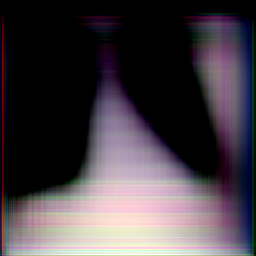

In [8]:
"""
图像生成
"""
args = Args()
args.latent_dim = 256
args.image_size = 256
args.num_codebook_vectors = 1024
args.beta = 0.25
args.image_channels = 3
args.dataset_path = r"../chex/"
args.device = "cuda"
args.batch_size = 1
args.epochs = 10000
args.learning_rate = 2.25e-05
args.beta1 = 0.5
args.beta2 = 0.9
args.disc_start = 5000
args.disc_factor = 1.
args.rec_loss_factor = 1
args.perceptual_loss_factor = 1.

model = train_vqgan.vqgan
dataset = load_data(args)
    

with tqdm(range(len(dataset))) as pbar:
    for i, imgs in zip(pbar, dataset):
        # imgs = torch.zeros(size=[1,3,256,256])
        imgs = imgs.to(device=args.device)
        decoded_images, _, q_loss = model(imgs)
        output_img = get_img(decoded_images)

output_img


In [ ]:
"""
vqgan 训练
"""
args = Args()
args.latent_dim = 256
args.image_size = 256
args.num_codebook_vectors = 1024
args.beta = 0.25
args.image_channels = 3
args.dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/"
args.device = "cuda"
args.batch_size = 5
args.epochs = 50
args.learning_rate = 2.25e-05
args.beta1 = 0.5
args.beta2 = 0.9
args.disc_start = 5000
args.disc_factor = 1.
args.rec_loss_factor = 1
args.perceptual_loss_factor = 1.


train_vqgan = TrainVQGAN(args)
